In [59]:
from mesa import Agent, Model

from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import ContinuousSpace

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

In [60]:
class FlockAgent(Agent):
    def __init__ (self, id, model, x, y):
        super().__init__(id, model)

        self.position = np.array((x,y) , dtype = np.float64)

        vec = (np.random.rand(2) - 0.5) * 10
        self.velocity = np.array(vec, dtype = np.float64)

        vec = (np.random.rand(2) - 0.5) / 2
        self.acceleration = np.array(vec, dtype = np.float64)

        self.max_force = 0.3
        self.max_speed = 5
        self.perception = 50

    def step(self):
        self.check_edges()
        self.check_with_neighbors()
        
        self.position = self.position + self.velocity
        self.velocity = self.velocity + self.acceleration

        if np.linalg.norm(self.velocity) > self.max_speed:
            self.velocity = self.velocity / np.linalg.norm(self.velocity) * self.max_speed

        self.acceleration = np.array([0, 0], dtype = np.float64)
        
        self.model.grid.move_agent(self, self.position)

    def check_edges(self):
        (x, y) = self.position

        if x > self.model.grid.x_max:
            x = self.model.grid.x_min
        elif x < self.model.grid.x_min:
            x = self.model.grid.x_max

        if y > self.model.grid.y_max:
            y = self.model.grid.y_min
        elif y < self.model.grid.y_min:
            y = self.model.grid.y_max

        self.position = np.array((x, y), dtype = np.float64)

    def check_with_neighbors(self):
        alignment = self.align()
        cohesion = self.cohesion()
        separation = self.separation()

        self.acceleration = self.acceleration + alignment
        self.acceleration = self.acceleration + cohesion
        self.acceleration = self.acceleration + separation

    def align(self):
        steering = np.array([0, 0], dtype = np.float64)
        avg_vector = np.array([0, 0], dtype = np.float64)
        total = 0

        for agent in self.model.grid.get_neighbors(self.pos, radius = self.perception, include_center = False):
            avg_vector += agent.velocity
            total += 1

        if total > 0:
            avg_vector = avg_vector / total
            avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            steering = avg_vector - self.velocity

        return steering
    
    def cohesion(self):
        steering = np.array([0, 0], dtype = np.float64)
        center_of_mass = np.array([0, 0], dtype = np.float64)
        total = 0

        for agent in self.model.grid.get_neighbors(self.pos, radius = self.perception, include_center = False):
            center_of_mass += agent.position
            total += 1

        if total > 0:
            center_of_mass /= total
            vec_to_com = center_of_mass - self.position
            if np.linalg.norm(vec_to_com) > 0:
                vec_to_com = (vec_to_com / np.linalg.norm(vec_to_com)) * self.max_speed

            steering = vec_to_com - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = (steering / np.linalg.norm(steering)) * self.max_force

        return steering
    
    def separation(self):
        steering = np.array([0, 0], dtype = np.float64)
        avg_vector = np.array([0, 0], dtype = np.float64)
        total = 0

        for agent in self.model.grid.get_neighbors(self.pos, radius = self.perception, include_center = False):
            dist = self.position - agent.position
            dist = (dist / np.linalg.norm(dist))
            avg_vector += dist
            total += 1

        if total > 0:
            avg_vector /= total
            if np.linalg.norm(avg_vector) > 0:
                avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            
            steering = avg_vector - self.velocity
            if np.linalg.norm(steering) > self.max_force:
                steering = (steering / np.linalg.norm(steering)) * self.max_force

        return steering

In [61]:
def get_particles(model):
    return np.asarray([agent.position for agent in model.schedule.agents])

In [62]:
class FlockModel(Model):
    def __init__ (self, num_agents, width, height):
        self.schedule = RandomActivation(self)
        self.grid = ContinuousSpace(width, height, torus = True)
        self.datacollector = DataCollector(model_reporters = {"particles": get_particles})

        for i in range(num_agents):
            x = np.random.rand() * width
            y = np.random.rand() * height
            agent = FlockAgent(i, self, x, y)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [63]:
WIDTH = 100
HEIGHT = 100
NUM_AGENTS = 100
MAX_ITERATIONS = 100

model = FlockModel(NUM_AGENTS, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()

In [64]:
all_positions = model.datacollector.get_model_vars_dataframe()

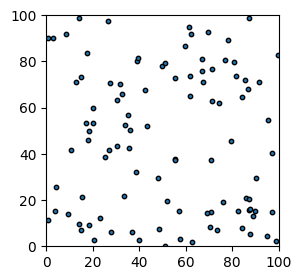

In [65]:
fig, ax = plt.subplots(figsize = (3, 3))
scatter = ax.scatter(all_positions.iloc[0, 0][:, 0], all_positions.iloc[0, 0][:, 1], s = 10, edgecolor = "k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i, 0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [66]:
anim